In [81]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

# Dynamic fee algorithm

"token1": {
          "decimals": "18",
          "symbol": "WETH"
        },
"token0": {
  "decimals": "6",
  "symbol": "USDC"
},

amount0: how many of USDC the pool received during this swap 

amount1: how many of WETH the pool received during this swap

if amount1 is positive, it means the pool received a sell order of WETH.

if amount1 is negative, it means the pool received a buy order of WETH.

In [134]:
df = pd.concat([pd.read_pickle('data/Merged_CEX_DEX_v2_p1.pkl'), pd.read_pickle('data/Merged_CEX_DEX_v2_p2.pkl'), pd.read_pickle('data/Merged_CEX_DEX_v2_p3.pkl')],axis=0)
df.drop_duplicates(inplace=True)
df.set_index('time_dex', inplace=True)

In [179]:
def zscore(series):
    return (series - series.mean()) / series.std()

# in percentage
def calculate_dynamic_buy_fees(row, f_min, f_max, w):
    return min(f_max, f_min + w * max(0, row['delta_p']))

def calculate_dynamic_sell_fees(row, f_min, f_max, w):
    return min(f_max, f_min - w * min(0, row['delta_p']))

# based on the trade direction 
def calculate_fee_direction(row):
    return (row['f_buy'] if row['amount1'] < 0 else row['f_sell'])*row['amountUSD']/100

# run after fee_directional is calculated, in USD
# TODO: minus gas
def calculate_arbitrageur_profit_dynamic(row):
    return row['LVR'] - row['dynamic_fee'] - row['tcost_usd']


def calculate_arbitrageur_profit_fixed(row):
    return row['LVR'] - row['pool_fee'] - row['tcost_usd']

In [180]:
f_min= 0.01
f_max = 0.1
# the steeper w is, the larger delta p is punished
w = (f_max - f_min)/np.abs(df['delta_p']).mean()
w = 0.1

print(f'w is {w: .3f}')

df['pool_fee'] = df['amountUSD']*0.05/100
df['delta_p'] = zscore(df['price_cex']-df['price_dex'])
df['f_buy'] = df.apply(lambda row: calculate_dynamic_buy_fees(row, f_min, f_max, w), axis=1)
df['f_sell'] = df.apply(lambda row: calculate_dynamic_sell_fees(row, f_min, f_max, w), axis=1)
df['dynamic_fee'] = df.apply(lambda row: calculate_fee_direction(row), axis=1)
df['arb_profit_dynamic'] =  df.apply(lambda row: calculate_arbitrageur_profit_dynamic(row), axis=1)
df['arb_profit_fixed'] =  df.apply(lambda row: calculate_arbitrageur_profit_fixed(row), axis=1)
df

w is  0.100


,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,LVR_clean_cumm,LVR,LVR_cumm,pool_fee,delta_p,f_buy,f_sell,dynamic_fee,arb_profit_dynamic,arb_profit_fixed
time_dex,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:23,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,...,0.311318,-2.468898,2.468898e+00,9.038135,0.154395,0.025440,0.010000,4.598518,-20.312978,-24.752595
2024-01-01 00:00:23,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,...,0.622636,-0.095501,2.564399e+00,0.349606,0.154395,0.025440,0.010000,0.177876,-10.509101,-10.680831
2024-01-01 00:00:47,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,...,2.205866,-17.344522,1.990892e+01,12.485547,0.724286,0.082429,0.010000,20.583333,-44.338026,-36.240241
2024-01-01 00:00:59,767.722283,-0.336412,766.824534,0xc10527cdbc055b7f9a8a4ad765b287190c861c51,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,247124,1.230578e+10,1.230578e-08,...,3.789096,-0.532617,2.044154e+01,0.383412,0.724286,0.082429,0.010000,0.632083,-8.101670,-7.852999
2024-01-01 00:01:23,170.905965,-0.074890,170.706032,0xf468072ca8f81e11655c252a37317e814b24872b,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,1.704067e+09,2673946,1.443436e+10,1.443436e-08,...,4.322326,-0.039934,2.048147e+01,0.085353,0.253825,0.035382,0.010000,0.060400,-88.143521,-88.168474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 23:59:23,-2280.293805,1.000000,2280.074254,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,1.706746e+09,284804,3.171776e+10,3.171776e-08,...,195902.785648,-0.053014,8.684891e+06,1.140037,-0.008847,0.010000,0.010885,0.248179,-20.911339,-21.803197
2024-01-31 23:59:47,15000.000000,-6.571360,14990.873565,0xcf99f91f0d834f26b8e7267ee99203bef3648edd,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,280947,2.010458e+10,2.010458e-08,...,195902.788663,0.019807,8.684891e+06,7.495437,0.013556,0.011356,0.010000,1.702306,-14.569501,-20.362632
2024-01-31 23:59:59,164318.889753,-71.961440,164190.258312,0x1fd0c666094d8c5dae247aa6c3c4c33fd21bdc91,0xe37e799d5077682fa0a244d46e5649f71457bd09,0xe37e799d5077682fa0a244d46e5649f71457bd09,1.706746e+09,1673514,2.378692e+10,2.378692e-08,...,195904.389250,115.180579,8.685006e+06,82.095129,-0.702250,0.010000,0.080225,16.419026,7.874078,-57.802025


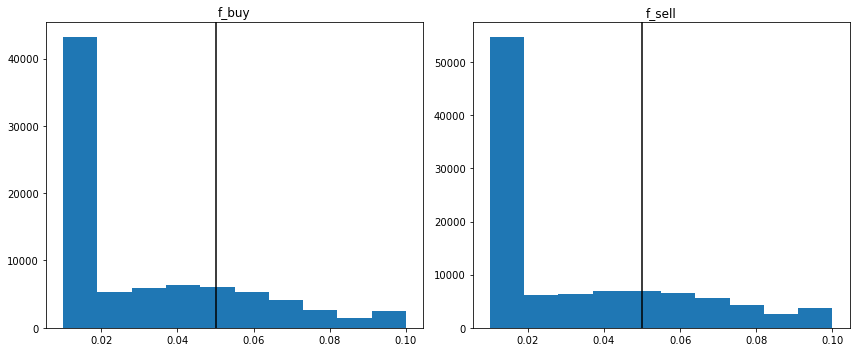

In [165]:
fig, axs = plt.subplots(1,2,figsize=(12,5))

axs[0].hist(df[df['amount1'] < 0]['f_buy'])
axs[1].hist(df[df['amount1'] > 0]['f_sell'])
axs[0].set_title('f_buy')
axs[1].set_title('f_sell')
axs[0].axvline(x=0.05, color='black')
axs[1].axvline(x=0.05, color='black')
plt.tight_layout()
plt.show()

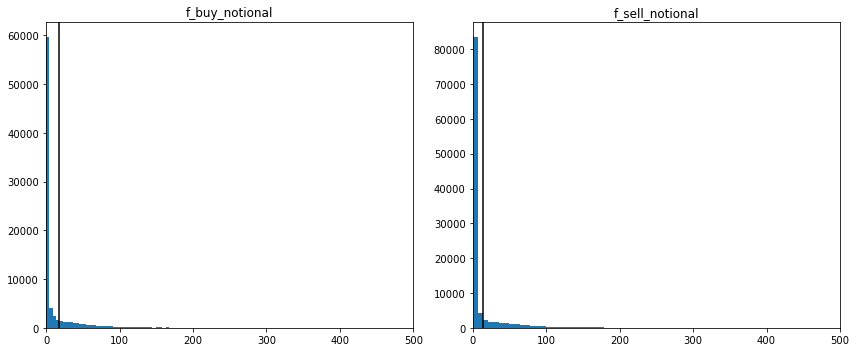

In [173]:
fig, axs = plt.subplots(1,2,figsize=(12,5))

avg_buy, avg_sell = df[df['amount1'] < 0]['dynamic_fee'].mean(), df[df['amount1'] > 0]['dynamic_fee'].mean()

axs[0].hist(df[df['amount1'] < 0]['dynamic_fee'],bins=1000)
axs[0].set_xlim(0,500)
axs[1].hist(df[df['amount1'] > 0]['dynamic_fee'],bins=1000)
axs[0].set_title('f_buy_notional')
axs[1].set_title('f_sell_notional')
axs[1].set_xlim(0,500)
axs[0].axvline(x=avg_buy, color='black')
axs[1].axvline(x=avg_sell, color='black')
plt.tight_layout()
plt.show()

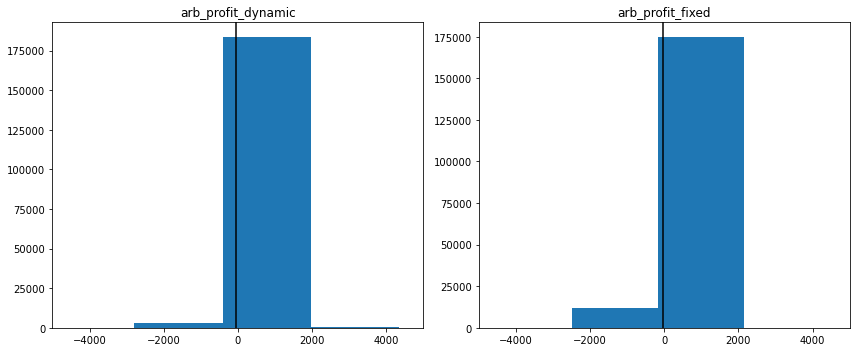

In [186]:
# only looking at average, omit big outliers 
fig, axs = plt.subplots(1,2,figsize=(12,5))
avg_dynamic, avg_fixed = df['arb_profit_dynamic'].mean(), df['arb_profit_fixed'].mean()
axs[0].hist(df['arb_profit_dynamic'],bins=100)
axs[0].set_title('arb_profit_dynamic')
axs[0].axvline(x=avg_dynamic, color='black')
axs[0].set_xlim(-5000, 5000)


axs[1].hist(df['arb_profit_fixed'],bins=100)
axs[1].set_title('arb_profit_fixed')
axs[1].axvline(x=avg_fixed, color='black')
axs[1].set_xlim(-5000, 5000)

plt.tight_layout()
plt.show()

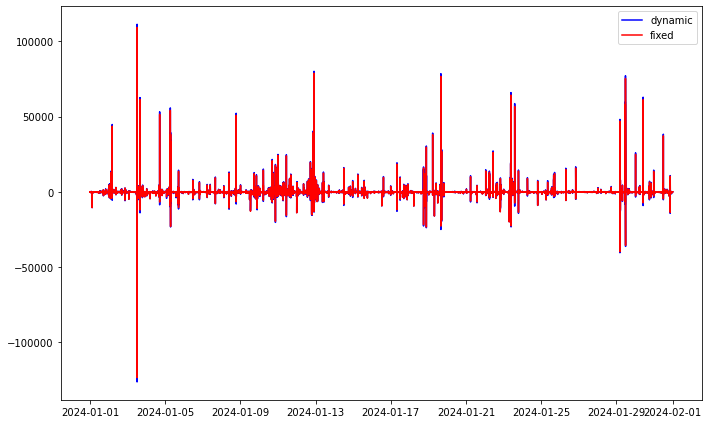

In [187]:
plt.figure(figsize=(10, 6))
plt.plot(df['arb_profit_dynamic'], color='blue', label='dynamic')
plt.plot(df['arb_profit_fixed'], color='r', label='fixed')
plt.legend()  # Adding a legend to identify each line
plt.tight_layout()  # Adjust layout to not cut off elements
plt.show()  # Display the plot

In [188]:
# only take postive LVR
df[df['LVR']>0]['arb_profit_dynamic'].sum()/df[df['LVR']>0]['arb_profit_fixed'].sum()

1.755338372300377

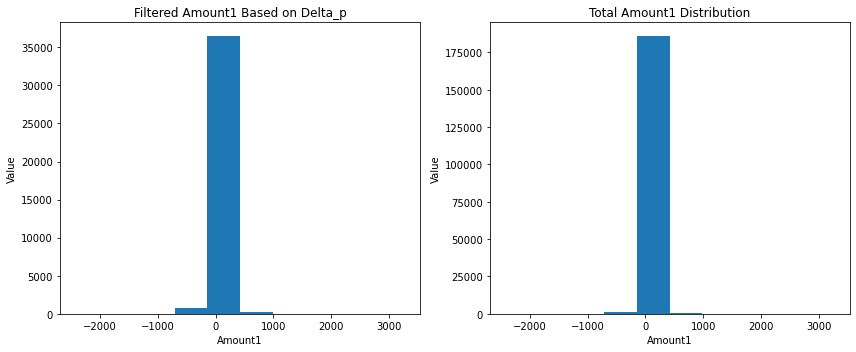

In [85]:
# top and bottom 10% of delta p
threshold_top_delta_p = df['delta_p'].quantile(0.9)
threshold_bottom_delta_p = df['delta_p'].quantile(0.1)

# around 2% of total transaction
fig, axs = plt.subplots(1,2,figsize=(12,5))

filtered = df[(df['delta_p'] > threshold_top_delta_p) | (df['delta_p'] < threshold_bottom_delta_p)]
# Box Plot for Filtered Data
axs[0].hist(filtered['amount1'])
axs[0].set_title('Filtered Amount1 Based on Delta_p')
axs[0].set_xlabel('Amount1')
axs[0].set_ylabel('Value')

# Box Plot for Unfiltered Data
axs[1].hist(df['amount1'])
axs[1].set_title('Total Amount1 Distribution')
axs[1].set_xlabel('Amount1')
axs[1].set_ylabel('Value')

plt.tight_layout()
plt.show()

# when there's big price difference, trading volume is bigger 


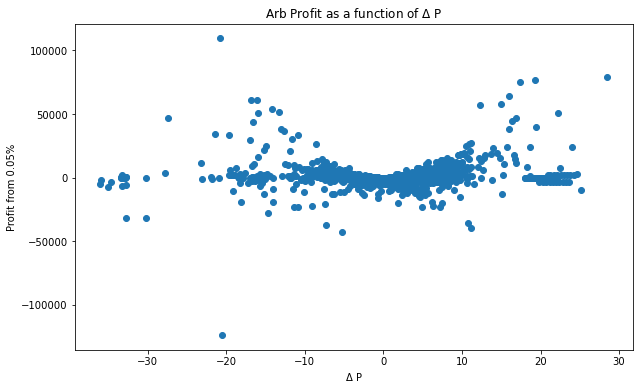

In [190]:
plt.figure(figsize=(10, 6))
plt.scatter(df['delta_p'].to_numpy(), df['arb_profit_fixed'].to_numpy())

plt.title('Arb Profit as a function of $\Delta$ P')  # Title of the plot
plt.ylabel('Profit from 0.05%')  # X-axis label
plt.xlabel('$\Delta$ P')  # Y-axis label
# plt.legend()  # Add a legend

plt.show()  # Display the plot